**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

In [1]:
!pip install --upgrade tensorflow -q

In [2]:
!pip install --upgrade keras-cv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.9 MB/s eta 0:00:00


**Imports**

In [3]:
# Default Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz

Using TensorFlow backend


**Randomnes and Configurations**

In [4]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
use_tpu = True#@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  use_tpu = False


if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

**Defining Functions**

In [6]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, steps, figsize, name_jpg):
  # Compute the confusion matrix
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  cm = confusion_matrix(true_categories, y_pred)

  # Compute classification metrics
  accuracy = accuracy_score(true_categories, y_pred)
  precision = precision_score(true_categories, y_pred, average='macro')
  recall = recall_score(true_categories, y_pred, average='macro')
  f1 = f1_score(true_categories, y_pred, average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

# Test
def test_prediction(model, test, steps):
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  test_accuracy = accuracy_score(true_categories, y_pred)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

In [7]:
# Initializate
images, labels = np.load('public_data_clean_balanced.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (6120, 96, 96, 3)
Labels shape:  (6120,)


In [8]:
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = labels
)

y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)

# Get the Shape of IN OUT
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [9]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [10]:
if use_tpu:
  BATCH_SIZE = 128
else:
  BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_testset(dataset):
    return (
            dataset
            .cache()
            .batch(BATCH_SIZE, drop_remainder=True)
        )


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

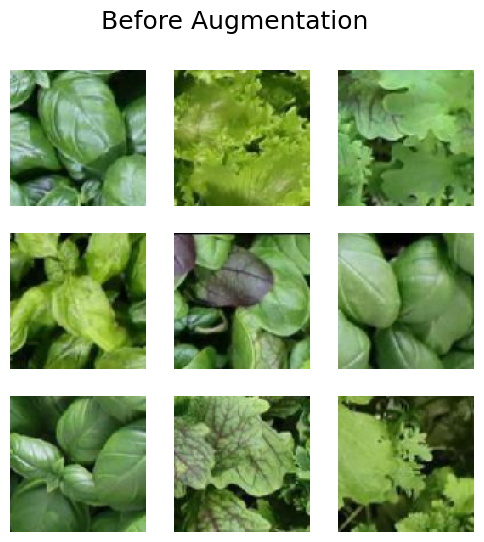

In [11]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

### Training

In [ ]:
# Stronger augmentations for contrastive
CONTRASTIVE_AUGMENTATION = {
    "crop_area_factor": (0.08, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.8,
    "brightness_factor": 0.2,
    "contrast_factor": 0.8,
    "saturation_factor": (0.3, 0.7),
    "hue_factor": 0.2,
}

# Weaker ones for supervised training
CLASSIFICATION_AUGMENTATION = {
    "crop_area_factor": (0.8, 1.0),
    "aspect_ratio_factor": (3 / 4, 4 / 3),
    "color_jitter_rate": 0.05,
    "brightness_factor": 0.1,
    "contrast_factor": 0.1,
    "saturation_factor": (0.1, 0.1),
    "hue_factor": 0.2,
}

In [ ]:
def get_augmenter(
    crop_area_factor,
    aspect_ratio_factor,
    color_jitter_rate,
    brightness_factor,
    contrast_factor,
    saturation_factor,
    hue_factor,
):
    return tfk.Sequential(
        [
            tfk.Input(shape=input_shape),
            kcv.layers.RandomFlip("horizontal"),
            kcv.layers.RandomCropAndResize(
                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                crop_area_factor=crop_area_factor,
                aspect_ratio_factor=aspect_ratio_factor,
            ),
            kcv.layers.RandomApply(
                kcv.layers.RandomColorJitter(
                    value_range=(0, 255),
                    brightness_factor=brightness_factor,
                    contrast_factor=contrast_factor,
                    saturation_factor=saturation_factor,
                    hue_factor=hue_factor,
                ),
                rate=color_jitter_rate,
            ),
        ]
    )

In [ ]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
kcv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

# get only the images from the dataset
train_contrastive_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE).map(
    lambda x, y: x, num_parallel_calls=AUTOTUNE
).map(contrastive_augmenter, num_parallel_calls=AUTOTUNE)

train_dataset = (
    train_dataset
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_contrastive_dataset = train_contrastive_dataset.prefetch(AUTOTUNE)
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

**Define the Model**

In [ ]:
# Define the encoder architecture
def get_encoder():
    return tfk.Sequential(
        [
            tfk.Input(shape=input_shape),
            tfk.applications.ConvNeXtBase(
                input_shape=input_shape,
                include_top=False,
                weights="imagenet",
            ),
            tfk.layers.GlobalAveragePooling2D(name="avg_pool"),
        ],
        name="encoder",
    )

In [ ]:
PROJECTION_WIDTH = 128

class SimCLRTrainer(kcv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )

def get_SimCLR_model():
    simclr_model = SimCLRTrainer(
        encoder=get_encoder(),
        augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
        projector=tfk.Sequential(
            [
                tfk.layers.Dense(PROJECTION_WIDTH, activation="relu"),
                tfk.layers.Dense(PROJECTION_WIDTH),
                tfk.layers.BatchNormalization(synchronized=True),
            ],
            name="projector",
        ),
    )

    simclr_model.compile(
        encoder_optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
        encoder_loss=kcv.losses.SimCLRLoss(
            temperature=0.1,
        ),
    )
    return simclr_model

if use_tpu:
  with strategy.scope():
    simclr_model = get_SimCLR_model()
else:
    simclr_model = get_SimCLR_model()

In [ ]:
simclr_history = simclr_model.fit(
    train_contrastive_dataset,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs=150,
)

In [ ]:
# Supervised finetuning of the pretrained encoder
def get_finetuning_model(encoder):
    finetune_model = tfk.Sequential(
        [
            tfk.Input(shape=input_shape),
            get_augmenter(**CLASSIFICATION_AUGMENTATION),
            encoder,
            tfk.layers.Dense(units=output_shape, activation='softmax'),
        ],
        name="finetuning_model",
    )
    finetune_model.compile(
        optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
        loss=tfk.losses.SparseCategoricalCrossentropy(),
        metrics=[tfk.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    return finetune_model

if use_tpu:
  with strategy.scope():
    finetune_model = get_finetuning_model(simclr_model.encoder)
else:
    finetune_model = get_finetuning_model(simclr_model.encoder)

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

finetune_history = finetune_model.fit(
    train_dataset, 
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs=200, 
    validation_data=val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks=callbacks
)

**Train the Model**

In [15]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

#callbacks = [early_stopping, lr_scheduler] NO NEED FOR ReduceLROnPlateau when training top
callbacks = [early_stopping]

history = model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
138/138 [==============================] - 76s 340ms/step - loss: 0.7033 - accuracy: 0.6748 - val_loss: 0.4092 - val_accuracy: 0.8281
Epoch 2/300
138/138 [==============================] - 34s 248ms/step - loss: 0.5401 - accuracy: 0.7439 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 3/300
138/138 [==============================] - 34s 244ms/step - loss: 0.5070 - accuracy: 0.7582 - val_loss: 0.3647 - val_accuracy: 0.8398
Epoch 4/300
138/138 [==============================] - 32s 231ms/step - loss: 0.4859 - accuracy: 0.7663 - val_loss: 0.3864 - val_accuracy: 0.8229
Epoch 5/300
138/138 [==============================] - 35s 258ms/step - loss: 0.4624 - accuracy: 0.7740 - val_loss: 0.3762 - val_accuracy: 0.8333
Epoch 6/300
138/138 [==============================] - 34s 246ms/step - loss: 0.4698 - accuracy: 0.7713 - val_loss: 0.3787 - val_accuracy: 0.8229
Epoch 7/300
138/138 [==============================] - 29s 207ms/step - loss: 0.4470 - accuracy: 0.7912 - val_loss: 0.3583 -

### Saving and Plotting

In [16]:
NAME_MODEL = "ConvNeXtCV_002"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

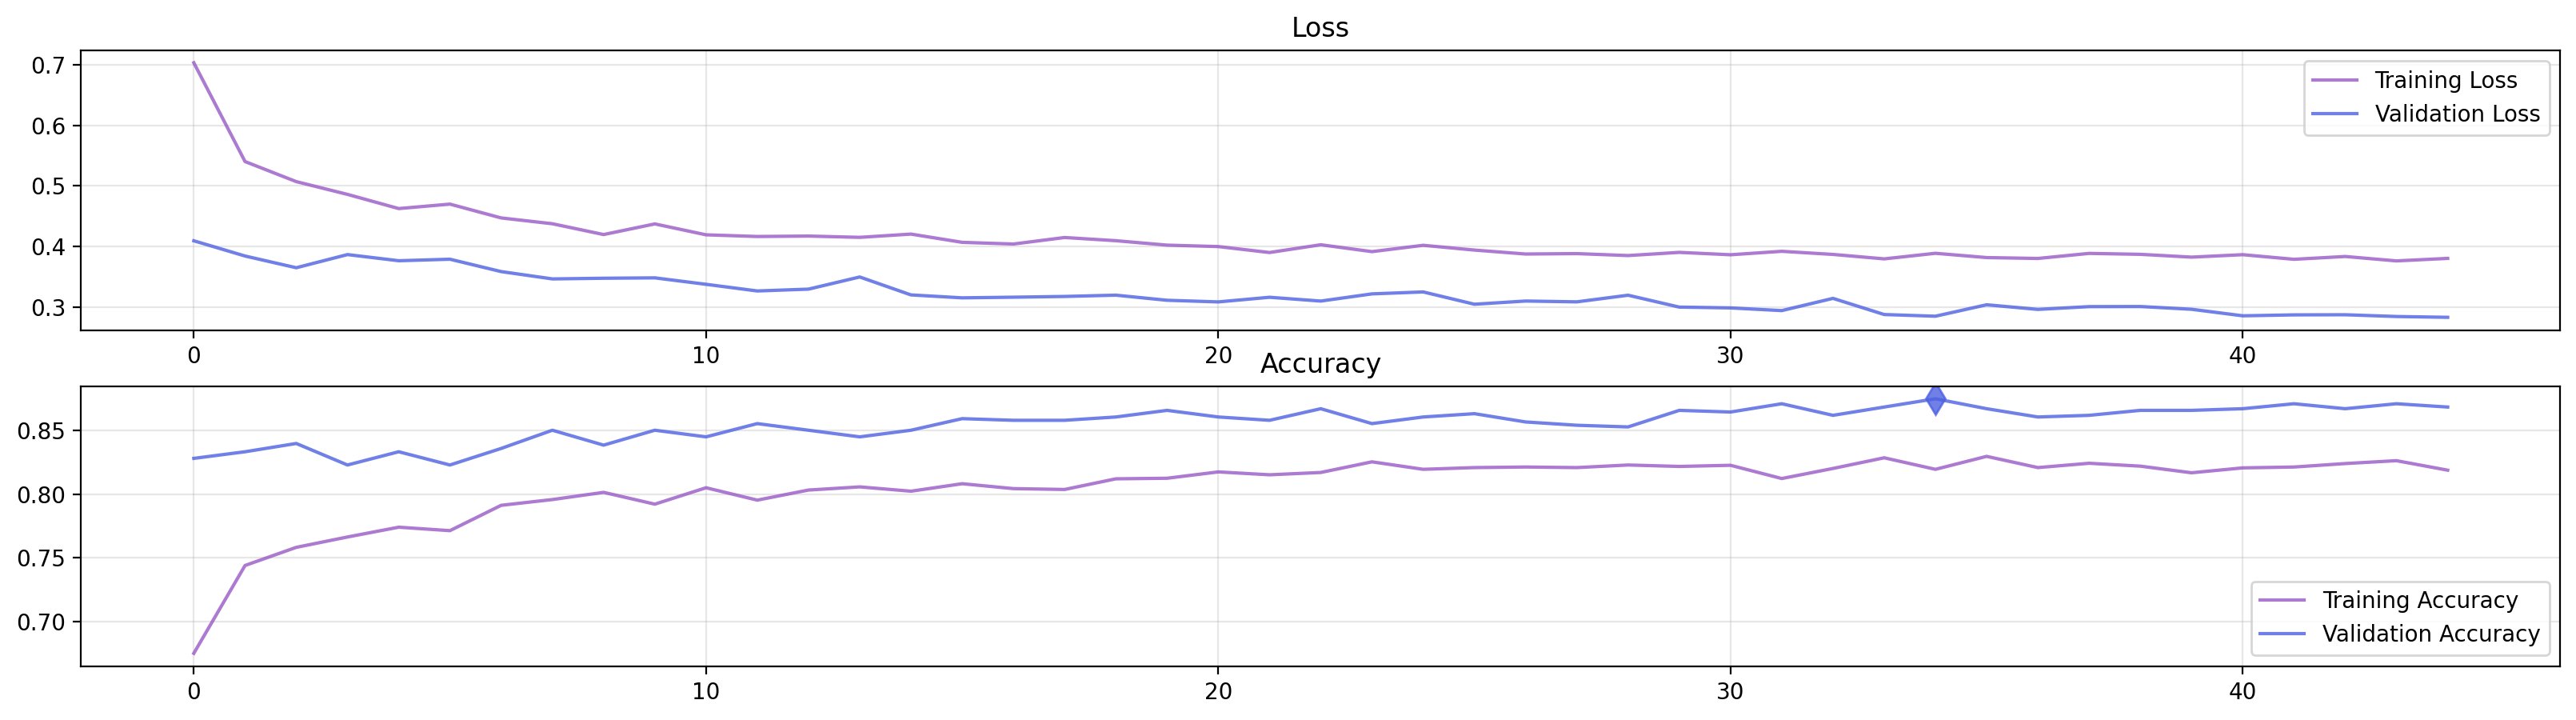

In [18]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.8817
Precision:	 0.8826
Recall:		 0.8815
F1:		 0.8816


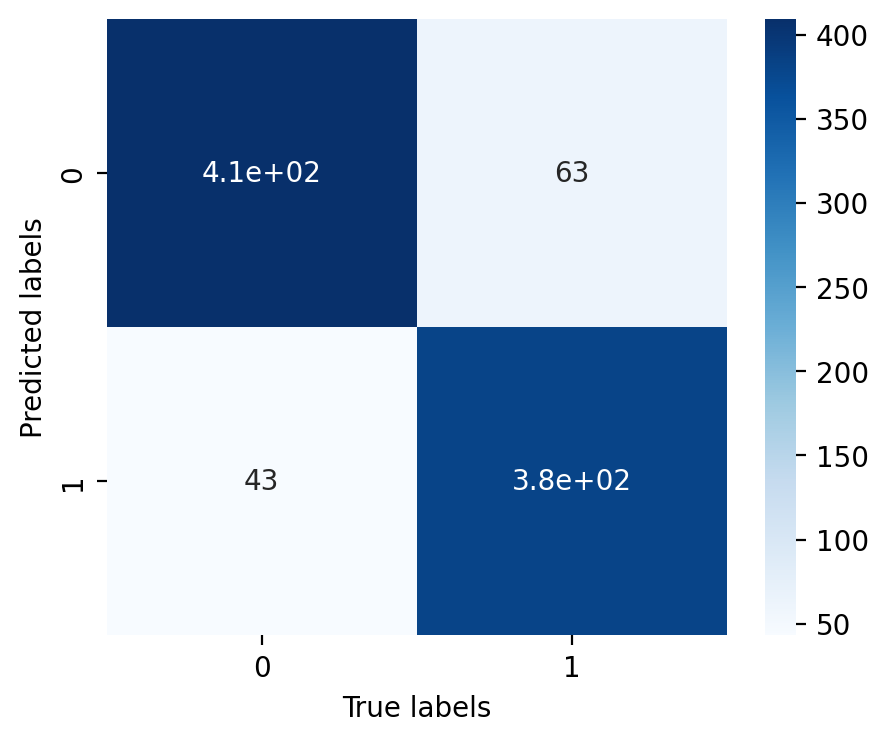

In [19]:
plot_confusion_matrix(model, test_dataset, len(X_test) // BATCH_SIZE, (5,4), NAME_CMATRIX)

**Save the Model**

In [20]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -q -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtCV_002/ (stored 0%)
  adding: ConvNeXtCV_002/variables/ (stored 0%)
  adding: ConvNeXtCV_002/variables/variables.index (deflated 77%)
  adding: ConvNeXtCV_002/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_002/saved_model.pb (deflated 92%)
  adding: ConvNeXtCV_002/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_002/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_002/assets/ (stored 0%)
  adding: ConvNeXtCV_002_plot.png (deflated 11%)
  adding: ConvNeXtCV_002_cmatrix.png (deflated 18%)


In [ ]:
!cp {NAME_MODEL}.zip drive/MyDrive/

In [ ]:
!cp augm_gio_split_001.npz drive/MyDrive/

**Delete the Model**

In [ ]:
del model, history

## Tuning

**Load the Model**

In [21]:
if use_tpu:
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    ft_model = tf.keras.models.load_model(NAME_MODEL, options=load_locally)
else:
  ft_model = tfk.models.load_model(NAME_MODEL)

**Count the Layers**

In [22]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  295



**Train only the Last Layers**

In [23]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

### Saving and Plotting

In [30]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Plot Loss**

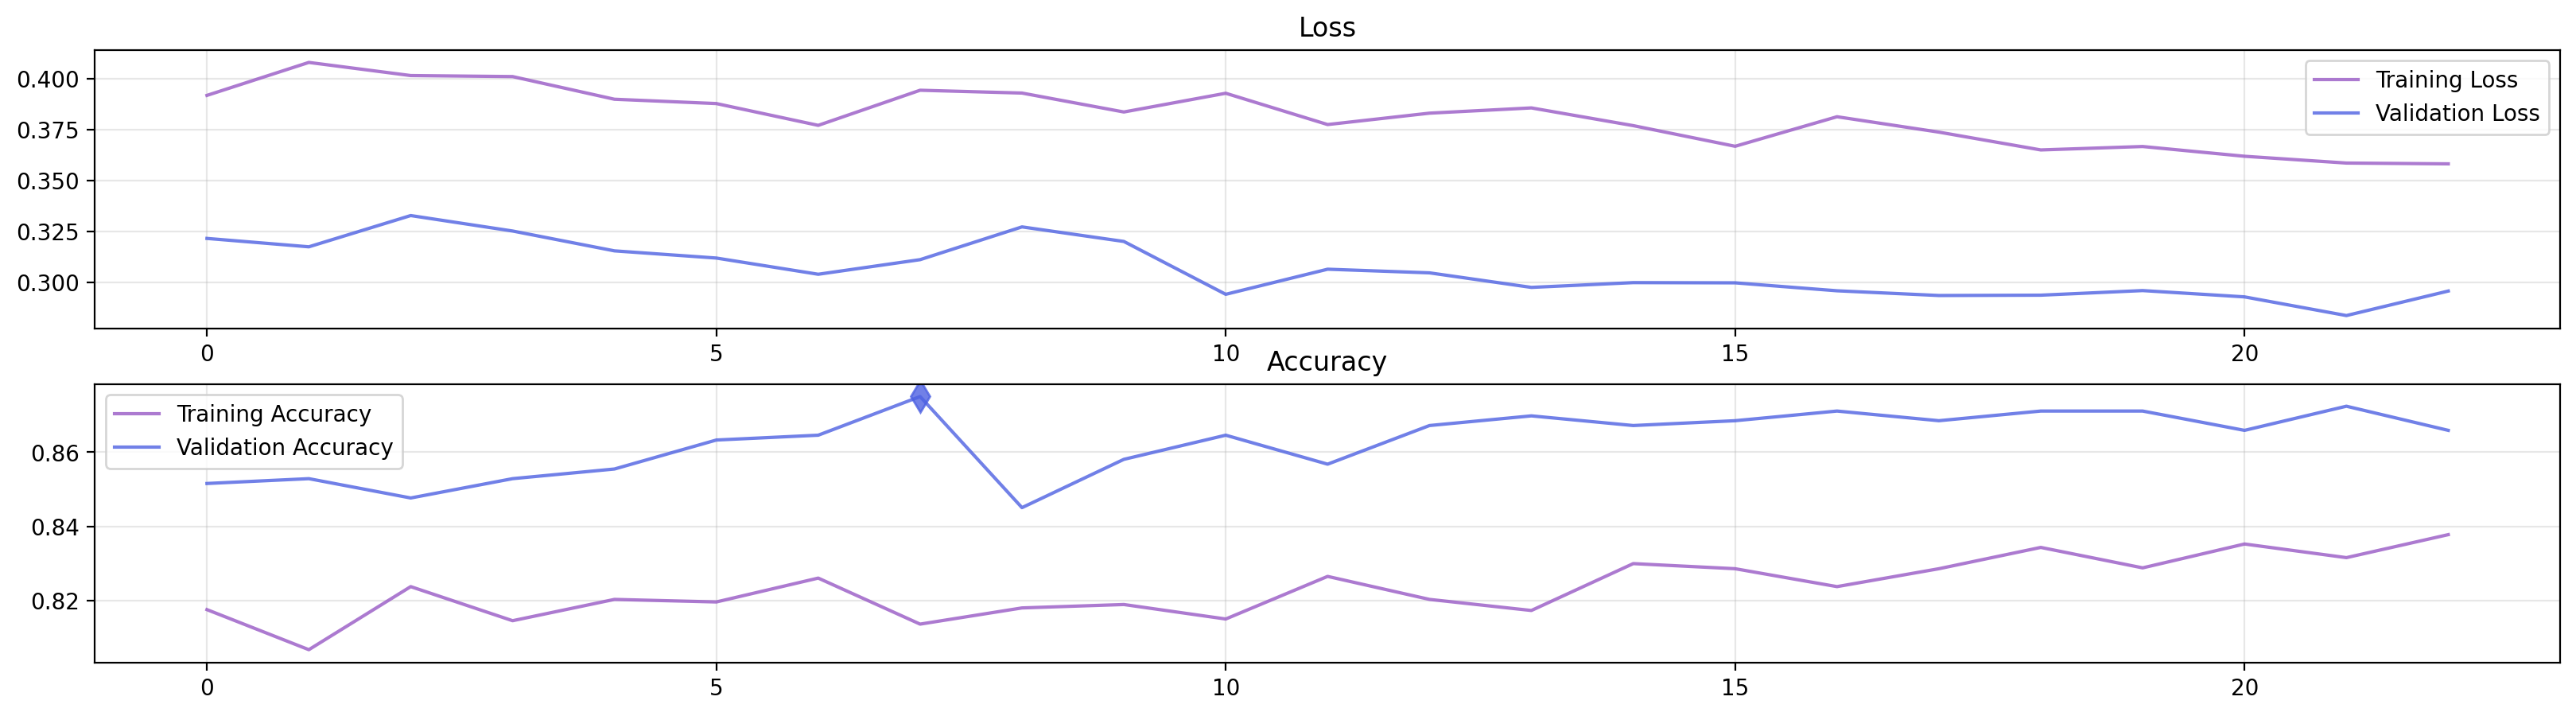

In [32]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

Exception ignored in: <function Executor.__del__ at 0x7f8c6a7e6a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Accuracy:	 0.8638
Precision:	 0.8638
Recall:		 0.8638
F1:		 0.8638


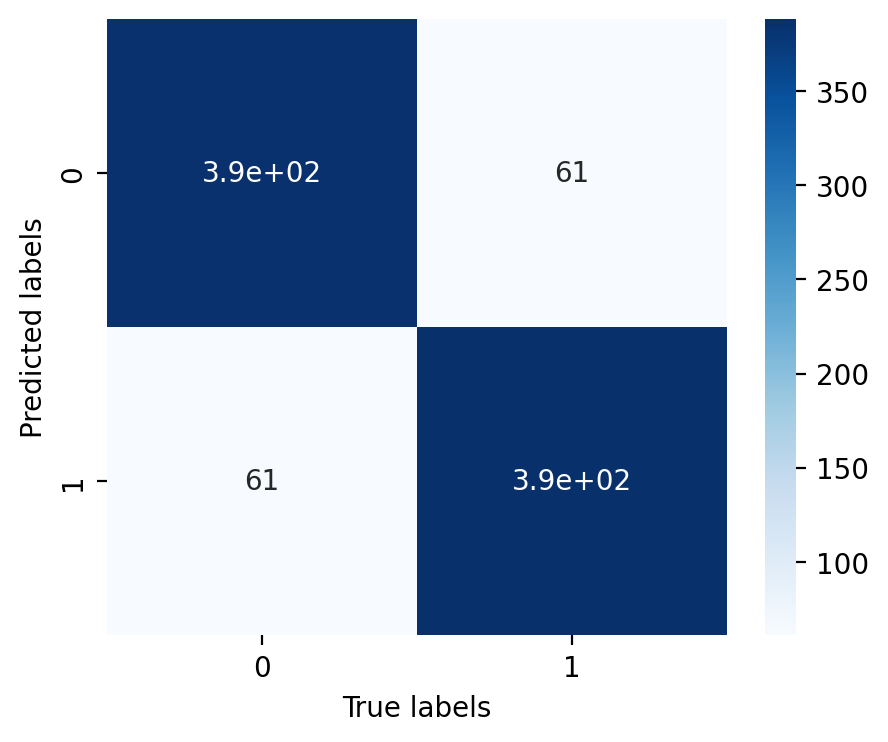

In [33]:
plot_confusion_matrix(ft_model, test_dataset, len(X_test) // BATCH_SIZE, (5,4), FT_CMATRIX)

**Save the Model**

In [34]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  ft_model.save(FT_NAME, options=save_locally)
else:
  ft_model.save(FT_NAME)

**Zip the Model and the Plots**

In [ ]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

	zip warning: name not matched: ConvNeXtV2_006_1_plot_Tuning.png
	zip warning: name not matched: ConvNeXtV2_006_1_cmatrix_Tuning.png
  adding: ConvNeXtV2_006_1_Tuning/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtV2_006_1_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXtV2_006_1_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtV2_006_1_Tuning/assets/ (stored 0%)


In [ ]:
!cp {FT_NAME}.zip drive/MyDrive/